In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import nltk

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SHYAM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SHYAM\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Load datasets
try:
    train_df = pd.read_csv(r"E:\sentimentanalysis\train.csv", encoding='ISO-8859-1')
    test_df = pd.read_csv(r"E:\sentimentanalysis\test.csv", encoding='ISO-8859-1')
except UnicodeDecodeError:
    try:
        train_df = pd.read_csv(r"E:\sentimentanalysis\train.csv", encoding='cp1252')
        test_df = pd.read_csv(r"E:\sentimentanalysis\test.csv", encoding='cp1252')
    except UnicodeDecodeError as e:
        print(f"Error: {e}")


In [3]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'#\w+', '', text)
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    else:
        text = ''
    return text

train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

In [4]:
# Check for missing values and fill or drop as needed
train_df = train_df.dropna(subset=['sentiment'])
test_df = test_df.dropna(subset=['sentiment'])

# Initialize tokenizer and process sequences
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_df['text'])

max_sequence_length = 100
X_train_sequences = tokenizer.texts_to_sequences(train_df['text'])
X_test_sequences = tokenizer.texts_to_sequences(test_df['text'])
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)

In [5]:
# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['sentiment'])
y_test = label_encoder.transform(test_df['sentiment'])

In [6]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_sequence_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    LSTM(32),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

C:\Users\SHYAM\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train the model
history = model.fit(X_train_padded, y_train, 
                    epochs=10, 
                    batch_size=32, 
                    validation_split=0.2, 
                    verbose=2)

Epoch 1/10
687/687 - 108s - 157ms/step - accuracy: 0.5914 - loss: 0.8895 - val_accuracy: 0.6949 - val_loss: 0.7255
Epoch 2/10
687/687 - 107s - 156ms/step - accuracy: 0.7431 - loss: 0.6704 - val_accuracy: 0.7037 - val_loss: 0.7058
Epoch 3/10
687/687 - 120s - 175ms/step - accuracy: 0.7981 - loss: 0.5525 - val_accuracy: 0.6831 - val_loss: 0.7696
Epoch 4/10
687/687 - 108s - 157ms/step - accuracy: 0.8425 - loss: 0.4544 - val_accuracy: 0.6847 - val_loss: 0.8593
Epoch 5/10
687/687 - 81s - 117ms/step - accuracy: 0.8736 - loss: 0.3691 - val_accuracy: 0.6736 - val_loss: 1.0277
Epoch 6/10
687/687 - 71s - 103ms/step - accuracy: 0.8945 - loss: 0.3060 - val_accuracy: 0.6807 - val_loss: 1.2089
Epoch 7/10
687/687 - 72s - 105ms/step - accuracy: 0.9072 - loss: 0.2694 - val_accuracy: 0.6658 - val_loss: 1.4282
Epoch 8/10
687/687 - 72s - 106ms/step - accuracy: 0.9158 - loss: 0.2389 - val_accuracy: 0.6660 - val_loss: 1.5678
Epoch 9/10
687/687 - 71s - 104ms/step - accuracy: 0.9273 - loss: 0.2107 - val_accura

In [8]:
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy:.4f}")

111/111 - 4s - 36ms/step - accuracy: 0.6610 - loss: 1.9070
Test Accuracy: 0.6610


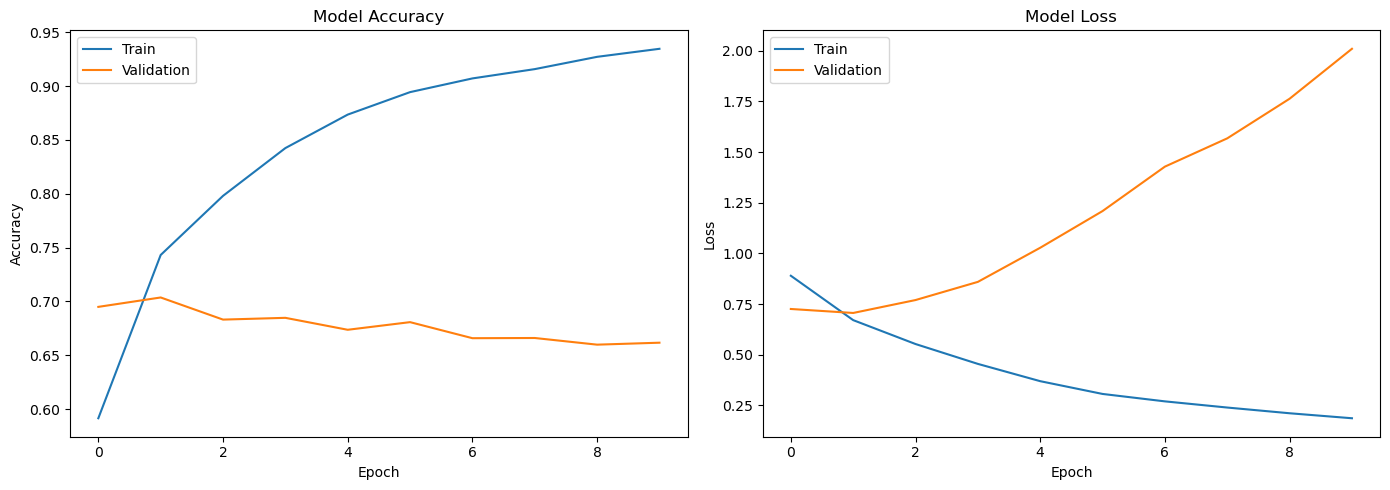

In [9]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()